In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches


# Load the CSV file (already done in your code)
#--stepwise
csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_Existing.csv"
Air_Emissions_County_Level_Existing = pd.read_csv(csv_path)

csv_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_New.csv"
Air_Emissions_County_Level_New = pd.read_csv(csv_path)

#--rep days

# Merge the two dataframes
# Combine the dataframes (rbind equivalent in R is concat in pandas)
Air_Emissions_County_Level = pd.concat([Air_Emissions_County_Level_Existing, Air_Emissions_County_Level_New], ignore_index=True)

new_england_states = ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut"]
new_england_state_codes = ["ME", "NH", "VT", "MA", "RI", "CT"]
new_england_state_id = ["23", "33", "50", "25", "44", "09"]

# Load a shapefile or GeoJSON of U.S. counties
# Use GeoPandas to read a GeoJSON file with New England county geometries
county_boundaries_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/New_England_county_boundaries.json"  # Replace with the actual path
county_boundaries = gpd.read_file(county_boundaries_path)
state_code_to_id = dict(zip(new_england_state_id, new_england_state_codes))
# Add the state_id column
county_boundaries["State"] = county_boundaries["state"].map(state_code_to_id)
county_boundaries['County'] = county_boundaries['name'] 

# Filter state boundaries to include only New England  states
state_boundaries_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Census Geo Data/US.json"  # Replace with the actual path
state_boundaries = gpd.read_file(state_boundaries_path)
state_boundaries = state_boundaries[state_boundaries['name'].isin(new_england_states)]

In [160]:
# Summarize data
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level.groupby(
    ['County', 'State', 'Pathway', 'Simulation']
).agg({
    'npv_total_air_emission_USD': 'sum',
    'mortality_person': 'sum',
    'npv_NOx_USD': 'sum',
    'npv_SO2_USD': 'sum',
    'npv_PM2.5_USD': 'sum',
    'npv_PM10_USD': 'sum',
    'npv_CO_USD': 'sum',
    'npv_VOC_USD': 'sum'
}).reset_index()

Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.groupby(
    ['County', 'State', 'Pathway']
).agg({
    'npv_total_air_emission_USD': 'mean',
    'mortality_person': 'mean',
    'npv_NOx_USD': 'mean',
    'npv_SO2_USD': 'mean',
    'npv_PM2.5_USD': 'mean',
    'npv_PM10_USD': 'mean',
    'npv_CO_USD': 'mean',
    'npv_VOC_USD': 'mean'
}).reset_index()

In [161]:
# Merge emissions data with county geometries
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.merge(county_boundaries, on=['County', 'State'], how='left')

# Categorize npv_total_air_emission_USD for visual differentiation
def categorize_emissions(value):
    if value <= 1e5:
        return "0-100K"
    elif value <= 5e5:
        return "100K-500K"
    elif value <= 1e6:
        return "500K-1M"
    elif value <= 2e6:
        return "1M-2M"
    elif value <= 5e6:
        return "2M-5M"
    elif value <= 10e6:
        return "5M-10M"
    else:
        return ">10M"


# Replace missing values in 'npv_total_air_emission_USD' with 0
Air_Emissions_County_Level_Summary['emission_category'] = Air_Emissions_County_Level_Summary['npv_total_air_emission_USD'].apply(categorize_emissions)

#Ensure data is gpd
Air_Emissions_County_Level_Summary = gpd.GeoDataFrame(
    Air_Emissions_County_Level_Summary,
    geometry='geometry'
)

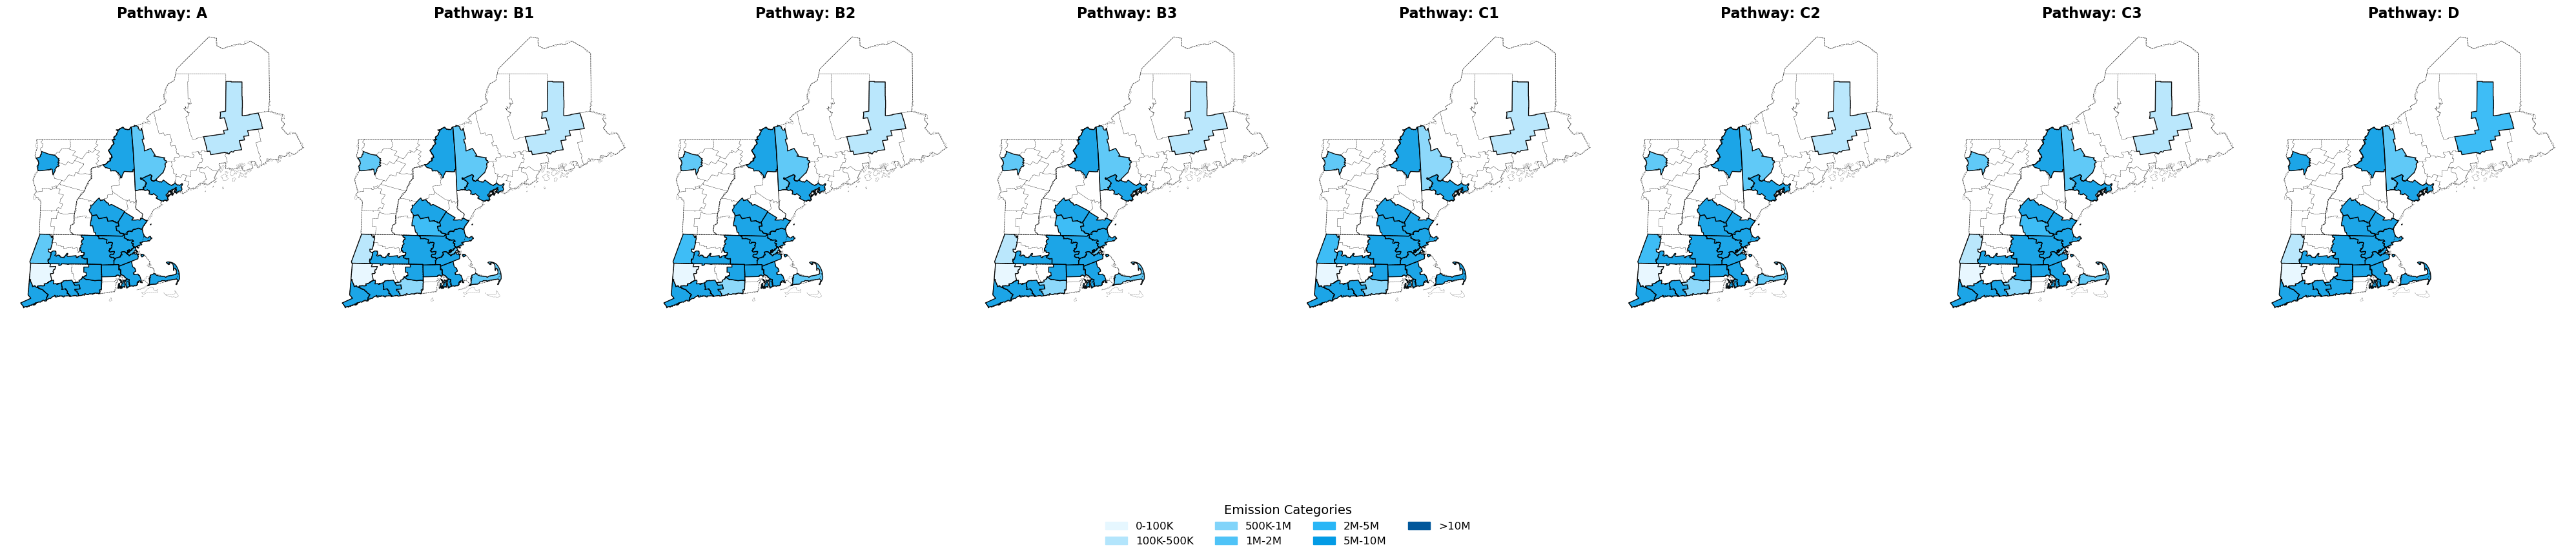

In [162]:
# Define improved color mapping

category_colors = {
    "0-100K": "#e6f7ff",      # Very light blue
    "100K-500K": "#b3e5fc",   # Light blue
    "500K-1M": "#81d4fa",     # Medium blue
    "1M-2M": "#4fc3f7",       # Intense blue
    "2M-5M": "#29b6f6",       # Deep blue
    "5M-10M": "#039be5",      # Dark blue
    ">10M": "#01579b"
}

# Create a custom colormap
custom_cmap = ListedColormap(list(category_colors.values())[:-1])  # Exclude "No Data"

# Create legend patches
legend_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in category_colors.items()
]

# Get unique pathways
unique_pathways = Air_Emissions_County_Level_Summary['Pathway'].unique()

# Create subplots for each pathway in one row
fig, axes = plt.subplots(1, len(unique_pathways), figsize=(40, 10), sharex=True, sharey=True)

# Loop through each pathway and create a plot
for ax, pathway in zip(axes, unique_pathways):
    filtered_df = Air_Emissions_County_Level_Summary[
        Air_Emissions_County_Level_Summary['Pathway'] == pathway
    ]
    
    # Add state boundaries with a distinct style
    state_boundaries.boundary.plot(ax=ax, color="black", linestyle="--", linewidth=0.5, alpha=0.8)
    
    # Add county boundaries with subtle styling
    county_boundaries.boundary.plot(ax=ax, color="black", linestyle="--", linewidth=0.2)
    

    # Plot the data using the custom colormap
    filtered_df.plot(
        ax=ax,
        column='emission_category',
        cmap=custom_cmap,
        legend=False,  # Legend will be added separately
        alpha=0.9,
        edgecolor="black"
    )
    
    # Set title for each subplot
    ax.set_title(f"Pathway: {pathway}", fontsize=16, fontweight="bold")
    ax.set_axis_off()

# Add a single legend for all plots
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=4,
    fontsize=12,
    frameon=False,
    title="Emission Categories",
    title_fontsize=14
)

# Adjust spacing and display the plot
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)  # Adjust space for legend
plt.show()


## Comparing pathways


In [163]:
Air_Emissions_County_Level

,County,State,Simulation,Pathway,npv_NOx_USD,npv_SO2_USD,npv_PM2.5_USD,npv_PM10_USD,npv_CO_USD,npv_VOC_USD,npv_total_air_emission_USD,mortality_person
0,Suffolk,MA,1,A,29839.595244,208766.904007,6.585495e+06,452172.537100,1.382886e+06,368706.997098,9.027868e+06,1.028231
1,Suffolk,MA,1,B1,7969.294408,24315.650535,2.850398e+06,195713.692029,5.985543e+05,159587.329522,3.836538e+06,0.361326
2,Suffolk,MA,1,B2,8009.292999,26260.291585,2.808296e+06,192822.866534,5.897132e+05,157230.115184,3.782331e+06,0.356224
3,Suffolk,MA,1,B3,7977.283765,25835.686364,2.843346e+06,195229.491828,5.970734e+05,159192.506777,3.828654e+06,0.360583
4,Suffolk,MA,1,C1,8120.011173,30278.501206,2.581232e+06,177232.285197,5.420323e+05,144517.365169,3.483413e+06,0.328104
...,...,...,...,...,...,...,...,...,...,...,...,...
206986,Rockingham,NH,289,D,198129.237517,806821.642836,2.291916e+07,0.000000,1.150386e+07,508923.705538,3.593690e+07,4.974867
206987,Rockingham,NH,29,D,198129.237517,806821.642836,2.291916e+07,0.000000,1.150386e+07,508923.705538,3.593690e+07,4.974867
206988,Rockingham,NH,291,D,198129.237517,806821.642836,2.291916e+07,0.000000,1.150386e+07,508923.705538,3.593690e+07,4.974867
206989,Rockingham,NH,292,D,198129.237517,806821.642836,2.291916e+07,0.000000,1.150386e+07,508923.705538,3.593690e+07,4.974867


In [164]:
import pandas as pd

# First GroupBy: Summing emissions and mortality per County, State, Pathway, and Simulation
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level.groupby(
    ['County', 'State', 'Pathway', 'Simulation']
).agg({
    'npv_total_air_emission_USD': 'sum',
    'mortality_person': 'sum',
    'npv_NOx_USD': 'sum',
    'npv_SO2_USD': 'sum',
    'npv_PM2.5_USD': 'sum',
    'npv_PM10_USD': 'sum',
    'npv_CO_USD': 'sum',
    'npv_VOC_USD': 'sum'
}).reset_index()

# Second GroupBy: Calculating mean, max, and min for specific columns per County, State, and Pathway
Air_Emissions_County_Level_Summary = Air_Emissions_County_Level_Summary.groupby(
    ['County', 'State', 'Pathway']
).agg(
    npv_total_air_emission_USD_mean=('npv_total_air_emission_USD', 'mean'),
    mortality_person_mean=('mortality_person', 'mean'),
    npv_total_air_emission_USD_max=('npv_total_air_emission_USD', 'max'),
    mortality_person_max=('mortality_person', 'max'),
    npv_total_air_emission_USD_min=('npv_total_air_emission_USD', 'min'),
    mortality_person_min=('mortality_person', 'min')
).reset_index()


In [165]:
Air_Emissions_County_Level_Summary

,County,State,Pathway,npv_total_air_emission_USD_mean,mortality_person_mean,npv_total_air_emission_USD_max,mortality_person_max,npv_total_air_emission_USD_min,mortality_person_min
0,Barnstable,MA,A,2.091731e+07,2.403331,2.172601e+07,2.498516,2.045621e+07,2.353291
1,Barnstable,MA,B1,4.595752e+06,0.432378,5.083739e+06,0.478263,4.369233e+06,0.410922
2,Barnstable,MA,B2,4.741288e+06,0.446282,5.225698e+06,0.492003,4.498066e+06,0.423303
3,Barnstable,MA,B3,4.628184e+06,0.435494,4.980904e+06,0.468666,4.410918e+06,0.414905
4,Barnstable,MA,C1,5.231713e+06,0.493495,5.568228e+06,0.525147,5.032318e+06,0.474720
...,...,...,...,...,...,...,...,...,...
195,Worcester,MA,B3,3.635817e+07,3.846107,4.135750e+07,4.373079,2.952701e+07,3.124724
196,Worcester,MA,C1,3.905493e+07,3.840148,4.250628e+07,4.180815,3.465084e+07,3.405145
197,Worcester,MA,C2,4.453353e+07,4.672567,4.967708e+07,5.218169,3.726682e+07,3.903382
198,Worcester,MA,C3,3.213625e+07,3.360598,3.695144e+07,3.858403,7.154107e+05,0.071589


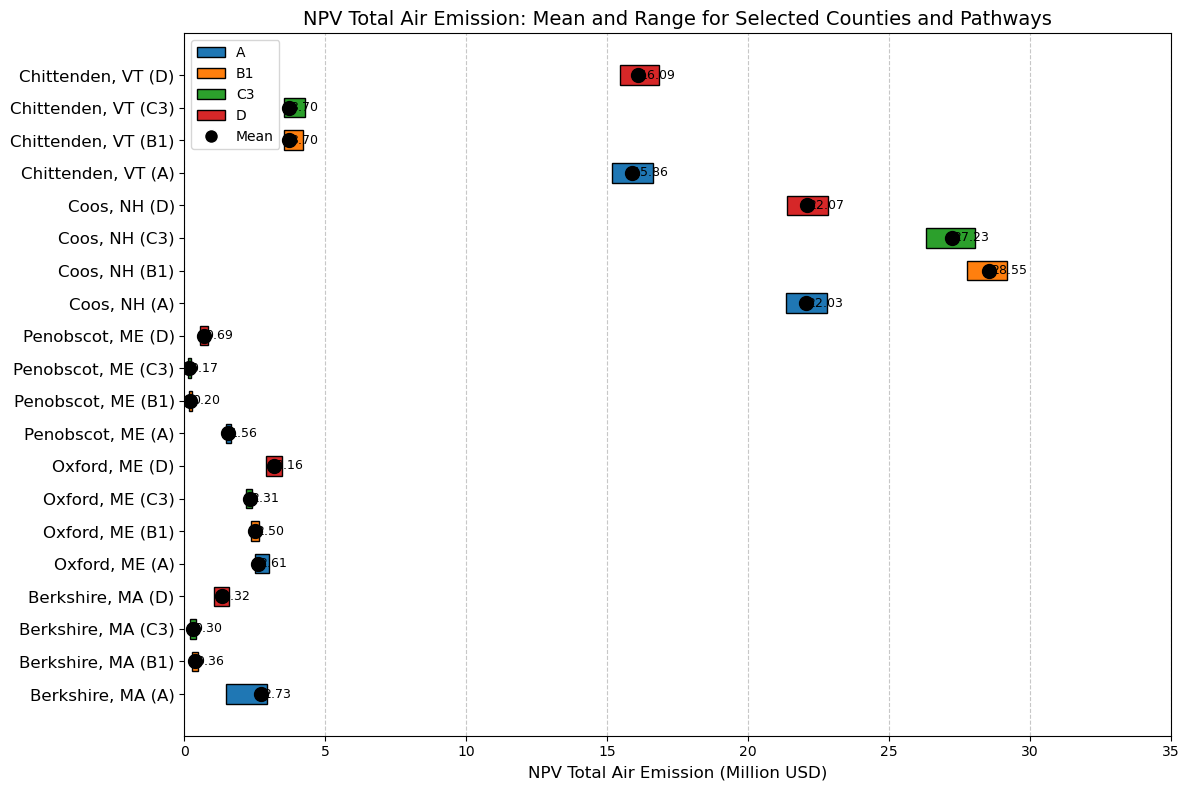

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),   # Replaced 'Carroll, NH' with 'Berkshire, MA'
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT')
]

# List of selected pathways
selected_pathways = ['A', 'D', 'B1', 'C3']

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin(selected_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall min, max, and mean
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean'),
    npv_total_air_emission_USD_min_mill=('npv_total_air_emission_USD_min', 'min'),
    npv_total_air_emission_USD_max_mill=('npv_total_air_emission_USD_max', 'max')
).reset_index()

# Convert USD to Million USD
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_min_mill'] = aggregated_df['npv_total_air_emission_USD_min_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_max_mill'] = aggregated_df['npv_total_air_emission_USD_max_mill'] / 1e6

# Create a unique identifier for each County and Pathway
aggregated_df['County_Pathway'] = aggregated_df['County'] + ', ' + aggregated_df['State'] + ' (' + aggregated_df['Pathway'] + ')'

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Set the figure size
plt.figure(figsize=(12, 8))

# Number of entries
num_entries = len(aggregated_df)

# Create a range for y-axis positions
y_positions = np.arange(num_entries)

# Define a color palette for pathways using a colormap
pathway_unique = aggregated_df['Pathway'].unique()
colors = plt.cm.tab10.colors  # Tab10 has 10 distinct colors
pathway_colors = {pathway: colors[i % len(colors)] for i, pathway in enumerate(pathway_unique)}

# Assign colors based on Pathway
aggregated_df['Color'] = aggregated_df['Pathway'].map(pathway_colors)

# Plot the range as horizontal bars
plt.barh(
    y_positions,
    aggregated_df['npv_total_air_emission_USD_max_mill'] - aggregated_df['npv_total_air_emission_USD_min_mill'],
    left=aggregated_df['npv_total_air_emission_USD_min_mill'],
    color=aggregated_df['Color'],
    edgecolor='black',
    height=0.6,
    label='Range'
)

# Plot the mean values as dots
plt.scatter(
    aggregated_df['npv_total_air_emission_USD_mean_mill'],
    y_positions,
    color='black',
    marker='o',
    s=100,  # Size of the dots
    label='Mean'
)

# Add numerical labels to the mean dots using positional index
for pos, row in enumerate(aggregated_df.itertuples(index=False)):
    plt.text(
        row.npv_total_air_emission_USD_mean_mill + 0.05,  # Slightly offset to the right
        y_positions[pos],
        f"{row.npv_total_air_emission_USD_mean_mill:.2f}",
        va='center',
        fontsize=9
    )

# Set y-ticks and labels
plt.yticks(y_positions, aggregated_df['County_Pathway'], fontsize=12)

# Labeling
plt.xlabel('NPV Total Air Emission (Million USD)', fontsize=12)
plt.title('NPV Total Air Emission: Mean and Range for Selected Counties and Pathways', fontsize=14)

# Add vertical grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create custom legend for Pathways
legend_elements = [Patch(facecolor=color, edgecolor='black', label=pathway) 
                   for pathway, color in pathway_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Mean',
                                  markerfacecolor='black', markersize=10))

plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Adjust x-axis limits to add some space on the right
plt.xlim(0, aggregated_df['npv_total_air_emission_USD_max_mill'].max() * 1.2)  # 20% extra space

# Improve layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()


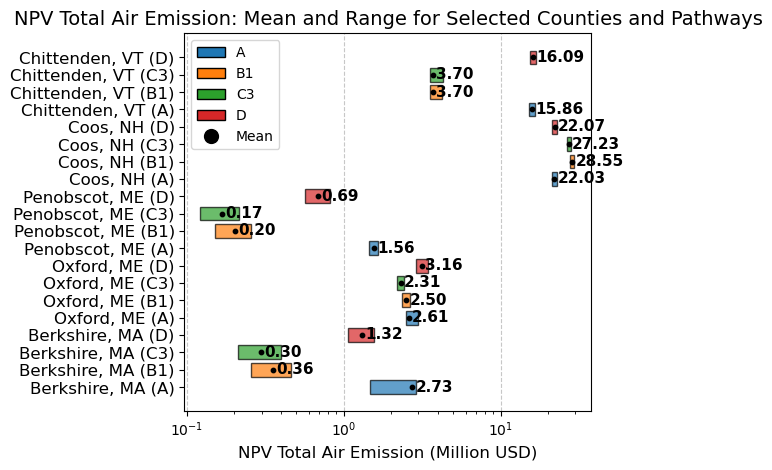

In [167]:
# ... [Previous Code] ...

# Set x-axis to logarithmic scale
plt.xscale('log')

# Plot the range as horizontal bars with increased height and transparency
plt.barh(
    y_positions,
    aggregated_df['npv_total_air_emission_USD_max_mill'] - aggregated_df['npv_total_air_emission_USD_min_mill'],
    left=aggregated_df['npv_total_air_emission_USD_min_mill'],
    color=aggregated_df['Color'],
    edgecolor='black',
    height=0.8,  # Increased height
    alpha=0.7,    # Semi-transparent
    label='Range'
)

# Plot the mean values as larger dots
plt.scatter(
    aggregated_df['npv_total_air_emission_USD_mean_mill'],
    y_positions,
    color='black',
    marker='o',
    s=10,  # Increased size
    label='Mean'
)

# Add numerical labels with a larger font size
for pos, row in enumerate(aggregated_df.itertuples(index=False)):
    plt.text(
        row.npv_total_air_emission_USD_mean_mill * 1.05,  # Slightly offset to the right
        y_positions[pos],
        f"{row.npv_total_air_emission_USD_mean_mill:.2f}",
        va='center',
        fontsize=11,
        fontweight='bold'
    )

# Set y-ticks and labels
plt.yticks(y_positions, aggregated_df['County_Pathway'], fontsize=12)

# Labeling
plt.xlabel('NPV Total Air Emission (Million USD)', fontsize=12)
plt.title('NPV Total Air Emission: Mean and Range for Selected Counties and Pathways', fontsize=14)

# Add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create custom legend
legend_elements = [Patch(facecolor=color, edgecolor='black', label=pathway) 
                   for pathway, color in pathway_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Mean',
                                  markerfacecolor='black', markersize=12))
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Adjust x-axis limits with a small buffer on both sides
plt.xlim(aggregated_df['npv_total_air_emission_USD_min_mill'].min() * 0.8, 
         aggregated_df['npv_total_air_emission_USD_max_mill'].max() * 1.3)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


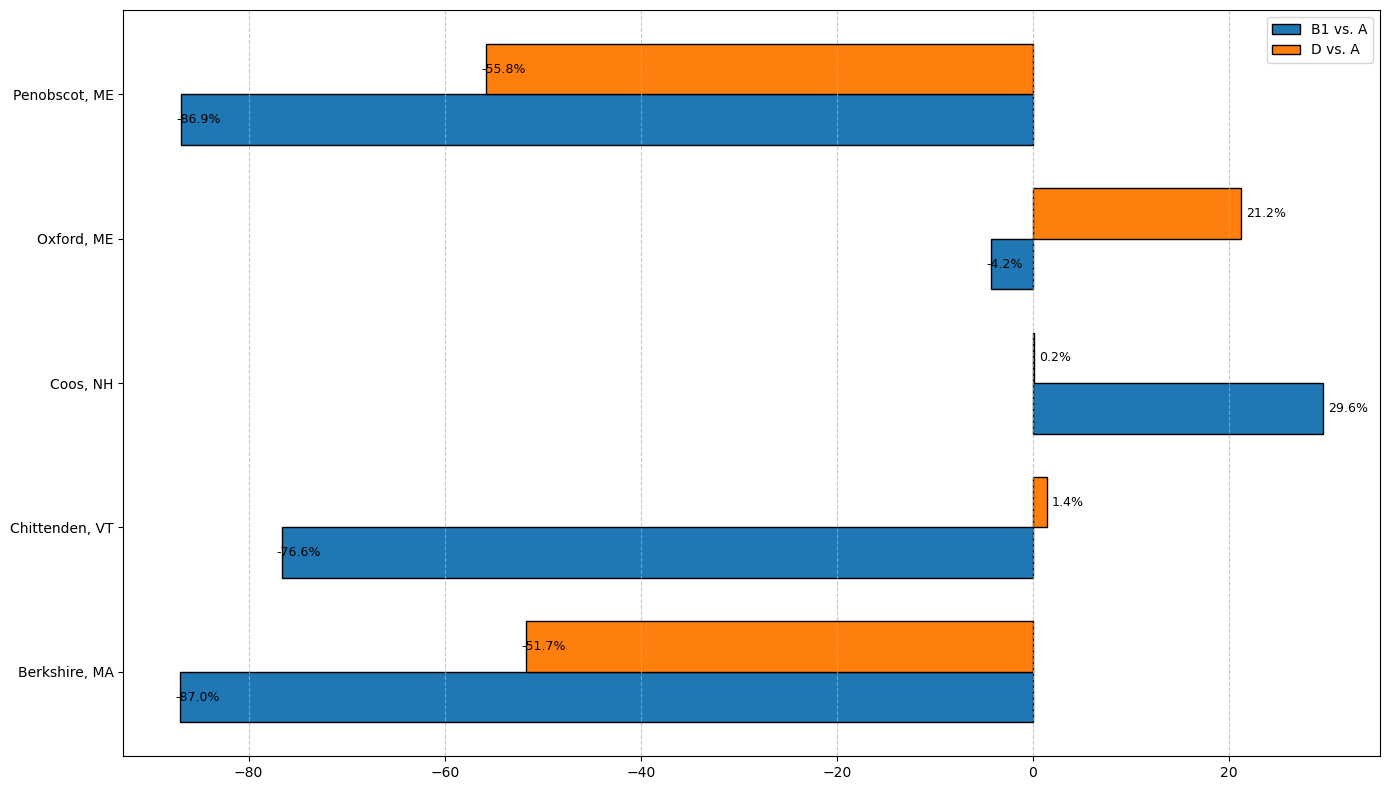

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),    # Replaced 'Carroll, NH' with 'Berkshire, MA'
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT'),
    ('Carroll', 'NH')
]

# List of selected pathways
selected_pathways = ['A', 'D', 'B1', 'C3']

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin(selected_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall mean emission
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean')
).reset_index()

# Convert USD to Million USD
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6

# Create a unique identifier for each County and Pathway
aggregated_df['County_Pathway'] = (
    aggregated_df['County'] + ', ' +
    aggregated_df['State'] + ' (' +
    aggregated_df['Pathway'] + ')'
)

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Pivot the DataFrame to have pathways as columns
pivot_df = aggregated_df.pivot_table(
    index=['County', 'State'],
    columns='Pathway',
    values='npv_total_air_emission_USD_mean_mill'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None  # Remove the aggregation name
pivot_df.rename(columns={
    'A': 'A_mean',
    'B1': 'B1_mean',
    'D': 'D_mean'
}, inplace=True)

# Check for missing data
missing_data = pivot_df[
    pivot_df[['A_mean', 'B1_mean', 'D_mean']].isnull().any(axis=1)
]
if not missing_data.empty:
    print("The following counties are missing data for one or more pathways:")
    print(missing_data[['County', 'State']])
    raise ValueError("Incomplete data detected. Please ensure all selected counties have data for pathways A, B1, and D.")

# Calculate percentage differences
pivot_df['B1_vs_A_pct_diff'] = ((pivot_df['B1_mean'] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100
pivot_df['D_vs_A_pct_diff'] = ((pivot_df['D_mean'] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100

# Combine County and State for labeling
pivot_df['County_State'] = pivot_df['County'] + ', ' + pivot_df['State']

# Define the positions and width for the bars
bar_width = 0.35
indices = np.arange(len(pivot_df))

# Create the plot
plt.figure(figsize=(14, 8))

# Define colors for comparisons
comparison_colors = {
    'B1 vs. A': plt.cm.tab10(0),  # Blue
    'D vs. A': plt.cm.tab10(1)    # Orange
}

# Plot bars for B1 vs. A
plt.barh(
    indices - bar_width/2,
    pivot_df['B1_vs_A_pct_diff'],
    height=bar_width,
    color=comparison_colors['B1 vs. A'],
    edgecolor='black',
    label='B1 vs. A'
)

# Plot bars for D vs. A
plt.barh(
    indices + bar_width/2,
    pivot_df['D_vs_A_pct_diff'],
    height=bar_width,
    color=comparison_colors['D vs. A'],
    edgecolor='black',
    label='D vs. A'
)

# Add labels and title
#plt.xlabel('Percentage Difference (%)', fontsize=12)
#plt.ylabel('County', fontsize=12)
#plt.title('Percentage Difference in NPV Total Air Emission Compared to Pathway A', fontsize=14)

# Set y-ticks
plt.yticks(indices, pivot_df['County_State'], fontsize=10)

# Add horizontal grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Annotate bars with percentage differences
for i in range(len(pivot_df)):
    # B1 vs. A
    plt.text(
        pivot_df.loc[i, 'B1_vs_A_pct_diff'] + (0.5 if pivot_df.loc[i, 'B1_vs_A_pct_diff'] >=0 else -0.5),
        indices[i] - bar_width/2,
        f"{pivot_df.loc[i, 'B1_vs_A_pct_diff']:.1f}%",
        va='center',
        fontsize=9
    )
    # D vs. A
    plt.text(
        pivot_df.loc[i, 'D_vs_A_pct_diff'] + (0.5 if pivot_df.loc[i, 'D_vs_A_pct_diff'] >=0 else -0.5),
        indices[i] + bar_width/2,
        f"{pivot_df.loc[i, 'D_vs_A_pct_diff']:.1f}%",
        va='center',
        fontsize=9
    )

# Adjust layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()


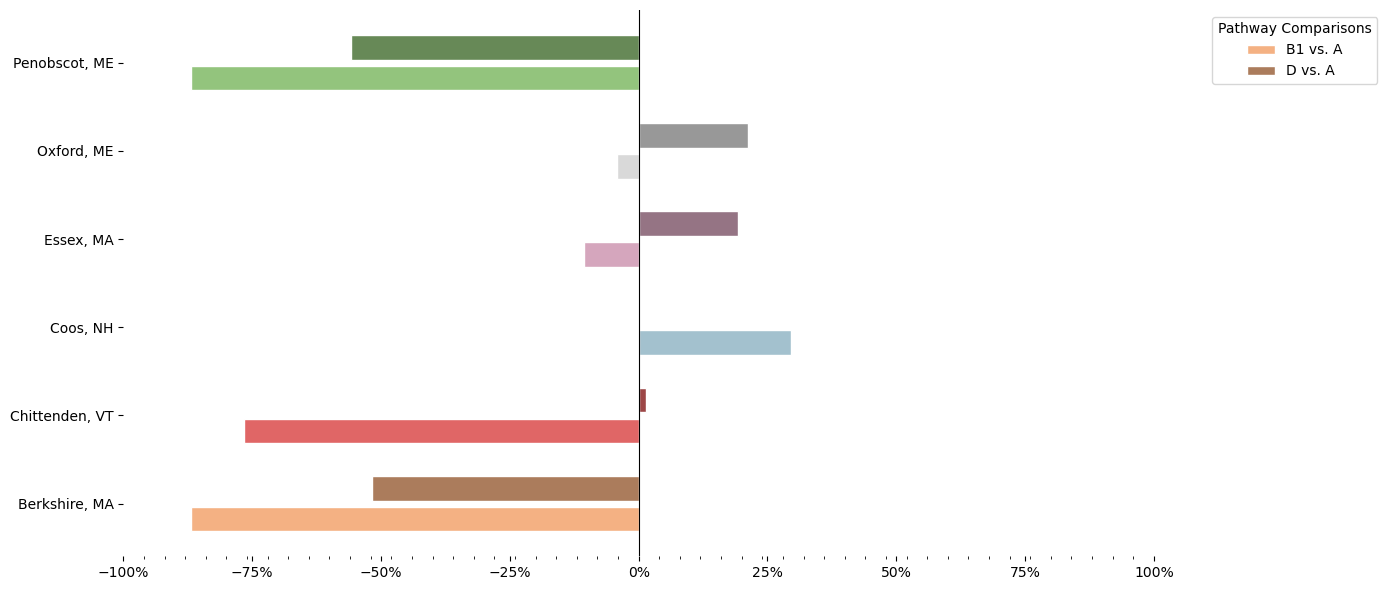

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, to_hex
import matplotlib.ticker as ticker

# Function to darken a color
def darken_color(color, amount=0.7):
    """
    Darken the given color by multiplying the RGB values by the given amount.
    """
    rgb = to_rgb(color)
    darkened = tuple(max(min(c * amount, 1), 0) for c in rgb)
    return darkened

# Assuming Air_Emissions_County_Level_Summary is your DataFrame
# Ensure it is already loaded in your environment

# Define the selected counties and their states
selected_counties = [
    ('Coos', 'NH'),
    ('Berkshire', 'MA'),
    ('Penobscot', 'ME'),
    ('Oxford', 'ME'),
    ('Chittenden', 'VT'),
    ('Carroll', 'NH'),
    ('Essex',	'MA')
]

# Pathway A is the baseline
baseline_pathway = 'A'

# Pathways to compare with A
comparison_pathways = ['B1', 'D']

# Define a list of pastel muted colors for the counties
# Ensure there are at least as many colors as there are counties
base_colors = [
    '#A3C1CE',  # Coos, NH - adjusted pastel blue
    '#F4B183',  # Berkshire, MA - adjusted pastel orange
    '#93C47D',  # Penobscot, ME - adjusted pastel green
    '#D9D9D9',  # Oxford, ME - adjusted pastel gray
    '#E06666',  # Chittenden, VT - adjusted pastel red
    '#D5A6BD',   # Carroll, NH - adjusted pastel pink
    '#D5A6BD'
]


# Create a mapping from County_State to base color
county_states = [f"{county}, {state}" for county, state in selected_counties]
county_color_map = {county_state: base_colors[i % len(base_colors)] for i, county_state in enumerate(county_states)}

# Convert the list of tuples to a set for efficient filtering
selected_set = set(selected_counties)

# Filter the DataFrame to include only the selected counties and the baseline and comparison pathways
filtered_df = Air_Emissions_County_Level_Summary[
    Air_Emissions_County_Level_Summary[['County', 'State']].apply(tuple, axis=1).isin(selected_set) &
    Air_Emissions_County_Level_Summary['Pathway'].isin([baseline_pathway] + comparison_pathways)
].copy()

# Check if the filtered DataFrame is empty
if filtered_df.empty:
    raise ValueError("No data found for the selected counties and pathways. Please check the county names, states, and pathways.")

# Aggregate the data per county and pathway to get overall mean emission
aggregated_df = filtered_df.groupby(['County', 'State', 'Pathway']).agg(
    npv_total_air_emission_USD_mean_mill=('npv_total_air_emission_USD_mean', 'mean'),
    npv_total_air_emission_USD_min_mill=('npv_total_air_emission_USD_min', 'min'),
    npv_total_air_emission_USD_max_mill=('npv_total_air_emission_USD_max', 'max')
).reset_index()

# Convert USD to Million USD for better readability
aggregated_df['npv_total_air_emission_USD_mean_mill'] = aggregated_df['npv_total_air_emission_USD_mean_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_min_mill'] = aggregated_df['npv_total_air_emission_USD_min_mill'] / 1e6
aggregated_df['npv_total_air_emission_USD_max_mill'] = aggregated_df['npv_total_air_emission_USD_max_mill'] / 1e6

# Optional: Sort the DataFrame for better visualization
aggregated_df.sort_values(['State', 'County', 'Pathway'], inplace=True)

# Pivot the DataFrame to have pathways as columns
pivot_df = aggregated_df.pivot_table(
    index=['County', 'State'],
    columns='Pathway',
    values='npv_total_air_emission_USD_mean_mill'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None  # Remove the aggregation name
if baseline_pathway in pivot_df.columns:
    pivot_df.rename(columns={baseline_pathway: 'A_mean'}, inplace=True)
else:
    raise ValueError("Pathway A is not present in the data. It is required as the baseline for comparison.")

# Ensure only Pathways B1 and D are present
missing_comparisons = [pathway for pathway in comparison_pathways if pathway not in pivot_df.columns]
if missing_comparisons:
    # For missing comparison pathways, fill with zero to assume 100% reduction
    for pathway in missing_comparisons:
        pivot_df[pathway] = 0
    print(f"Warning: The following pathways were missing and have been filled with zero to assume 100% reduction: {', '.join(missing_comparisons)}")

# Fill missing Pathway A with zero to handle division by zero
pivot_df['A_mean'] = pivot_df['A_mean'].fillna(0)

# Fill missing comparison pathways with zero to assume 100% reduction
for pathway in comparison_pathways:
    if pathway not in pivot_df.columns:
        pivot_df[pathway] = 0
    else:
        pivot_df[pathway] = pivot_df[pathway].fillna(0)

# Calculate percentage differences of comparison pathways compared to A
for pathway in comparison_pathways:
    pivot_df[f'{pathway}_vs_A_pct_diff'] = np.where(
        pivot_df['A_mean'] == 0,
        -100,  # If A_mean is zero, assume 100% reduction
        ((pivot_df[pathway] - pivot_df['A_mean']) / pivot_df['A_mean']) * 100
    )

# Combine County and State for labeling
pivot_df['County_State'] = pivot_df['County'] + ', ' + pivot_df['State']

# Select only necessary columns for plotting
percentage_diff_df = pivot_df[['County_State'] + [f'{pathway}_vs_A_pct_diff' for pathway in comparison_pathways]].copy()

# Melt the DataFrame to have pathways as rows for easier plotting
percentage_diff_df = percentage_diff_df.melt(
    id_vars=['County_State'],
    value_vars=[f'{pathway}_vs_A_pct_diff' for pathway in comparison_pathways],
    var_name='Comparison',
    value_name='Percentage_Difference'
)

# Extract pathway names from the 'Comparison' column
percentage_diff_df['Pathway'] = percentage_diff_df['Comparison'].str.replace('_vs_A_pct_diff', '')

# Sort the DataFrame for better visualization
percentage_diff_df.sort_values(['County_State', 'Pathway'], inplace=True)

# Define unique pathways for consistent coloring
unique_pathways = sorted(percentage_diff_df['Pathway'].unique())

# Define color map using the updated method to avoid deprecation warning
color_map = plt.get_cmap('tab10')  # Updated to use plt.get_cmap instead of plt.cm.get_cmap

# Create a list of colors based on county and pathway
# Each county has a base color; Pathway D is a darker shade
colors = []
for _, row in pivot_df.iterrows():
    county_state = row['County_State']
    base_color = county_color_map[county_state]
    for pathway in comparison_pathways:
        if pathway == 'B1':
            colors.append(base_color)
        elif pathway == 'D':
            colors.append(to_hex(darken_color(base_color, 0.7)))  # Darken the base color for D
        else:
            colors.append('gray')  # Default color, should not occur

# Define the positions and height for the bars
bar_height = 0.35  # Adjust based on the number of pathways
indices = np.arange(len(pivot_df))

# Create the plot
plt.figure(figsize=(14, 6))

# Plot each pathway as a separate set of bars
for i, pathway in enumerate(comparison_pathways):
    # Calculate the position offset
    offset = (i - 0.5) * bar_height
    # Extract the percentage differences for the pathway
    pct_diff = pivot_df[f'{pathway}_vs_A_pct_diff']
    # Assign colors for the pathway
    pathway_colors_plot = [colors[j * len(comparison_pathways) + i] for j in range(len(pivot_df))]
    # Plot the horizontal bars
    plt.barh(
        indices + offset,
        pct_diff,
        height=bar_height * 0.8,  # Slightly less than bar_height for spacing
        color=pathway_colors_plot,
        edgecolor='white',
        label=f'{pathway} vs. A'
    )

# Add labels and title
#plt.xlabel('Percentage Difference (%)', fontsize=12)
#plt.ylabel('County', fontsize=12)
#plt.title('Percentage Difference in NPV Total Air Emission Compared to Pathway A', fontsize=14)

# Set y-ticks
plt.yticks(indices, pivot_df['County_State'], fontsize=10)

# Configure x-axis ticks
# Set x-axis limits from -100% to +100%
plt.xlim(-100, 100)

# Set major ticks every 25%
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.PercentFormatter())

# Set minor ticks every 4%
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))

# Remove grid lines
# plt.grid(axis='x', linestyle='--', alpha=0.7)  # Removed as per requirement

# Remove annotations (labels) on bars by not adding plt.text

# Remove outside borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add legend outside the plot
plt.legend(title='Pathway Comparisons', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a vertical reference line at 0%
plt.axvline(0, color='black', linewidth=0.8)

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()
plt.savefig('Emissions_reduction.svg', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [170]:
print(filtered_df[filtered_df['County'] == 'Carroll'])


Empty DataFrame
Columns: [County, State, Pathway, npv_total_air_emission_USD_mean, mortality_person_mean, npv_total_air_emission_USD_max, mortality_person_max, npv_total_air_emission_USD_min, mortality_person_min]
Index: []


In [171]:
print("Unique Counties:", Air_Emissions_County_Level_Summary['County'].unique())
print("Unique States:", Air_Emissions_County_Level_Summary['State'].unique())


Unique Counties: ['Barnstable' 'Berkshire' 'Bristol' 'Chittenden' 'Coos' 'Cumberland'
 'Essex' 'Fairfield' 'Hampden' 'Hillsborough' 'Litchfield' 'Merrimack'
 'Middlesex' 'New Haven' 'New London' 'Newport' 'Norfolk' 'Oxford'
 'Penobscot' 'Providence' 'Rockingham' 'Suffolk' 'Windham' 'Worcester']
Unique States: ['MA' 'VT' 'NH' 'ME' 'CT' 'RI']


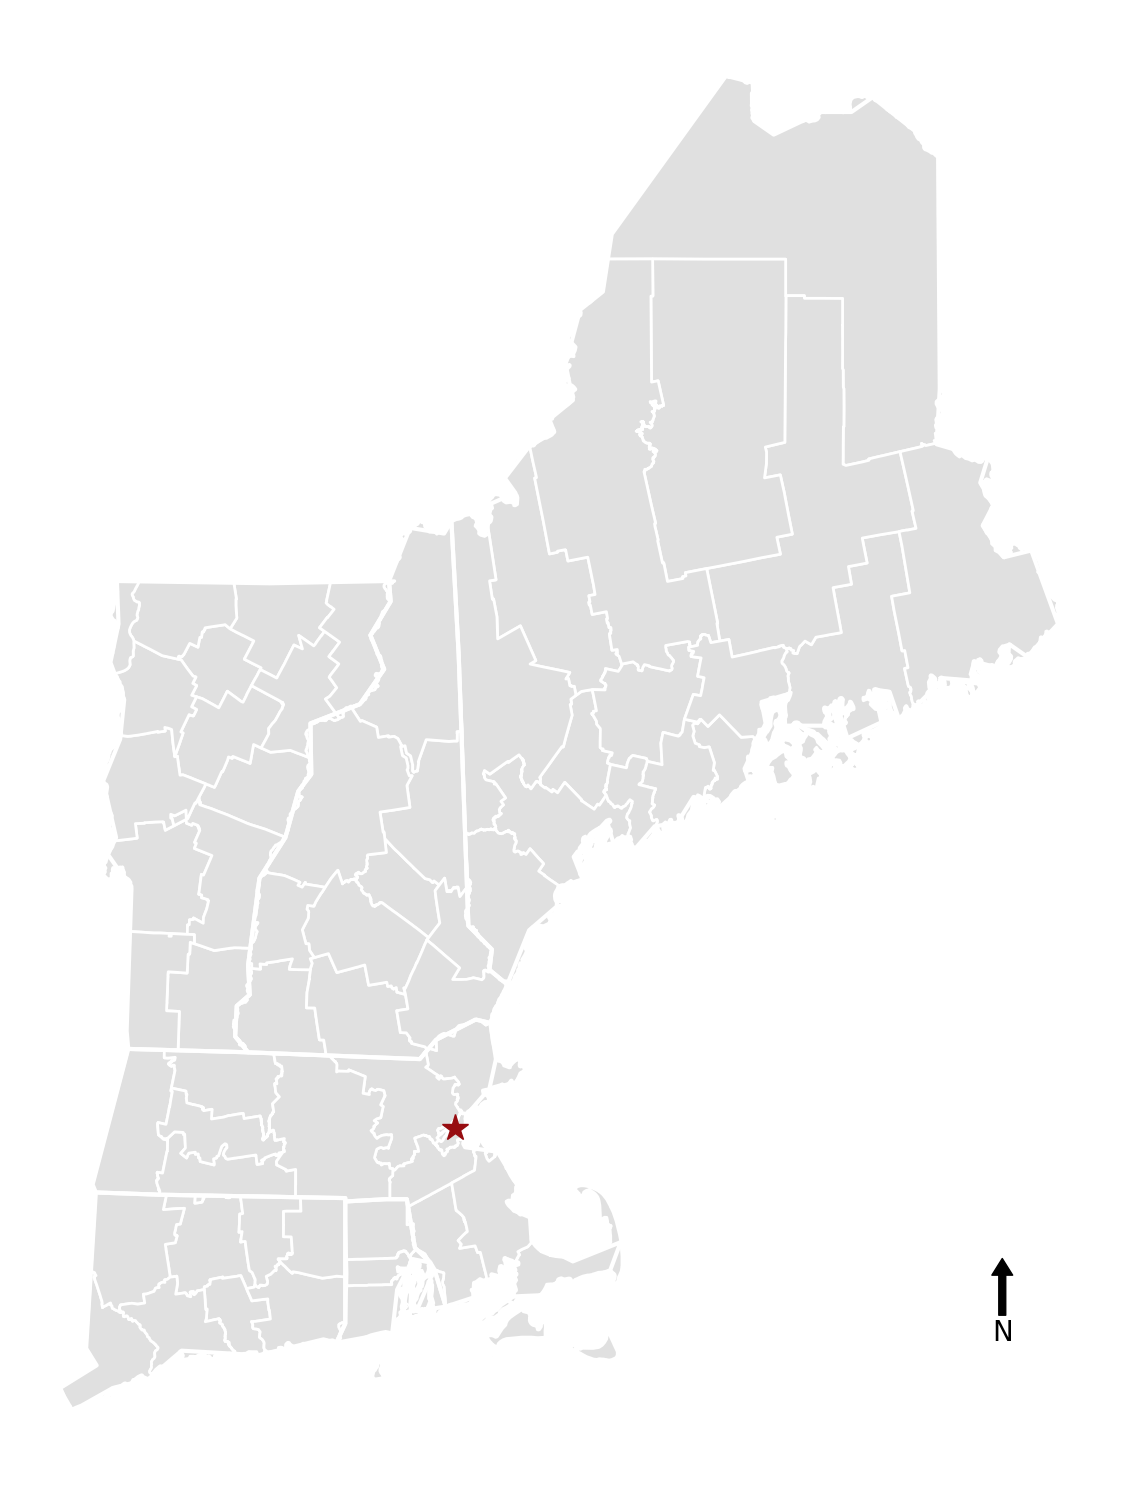

In [172]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Coordinates for Boston (latitude, longitude)
boston_coords = (-71.0589, 42.3601)  # (longitude, latitude)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))

# Plot county boundaries with gray fill and white edges
county_boundaries.plot(ax=ax, color="#e0e0e0", edgecolor="white", linewidth=2)

# Overlay state boundaries with black edges
state_boundaries.boundary.plot(ax=ax, color="white", linewidth=3)

# Add a north arrow
x, y, arrow_length = 0.9, 0.1, 0.05  # Adjust position and size
ax.annotate('N', xy=(x, y + arrow_length), xytext=(x, y),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Add a star for Boston
ax.plot(boston_coords[0], boston_coords[1], marker='*', color='#970C10', markersize=20, transform=ax.transData)

# Remove axis and annotations
ax.set_axis_off()
plt.savefig('Blank_NE_Map.svg', dpi=300, bbox_inches='tight')

# Display the plot
plt.tight_layout()
plt.show()


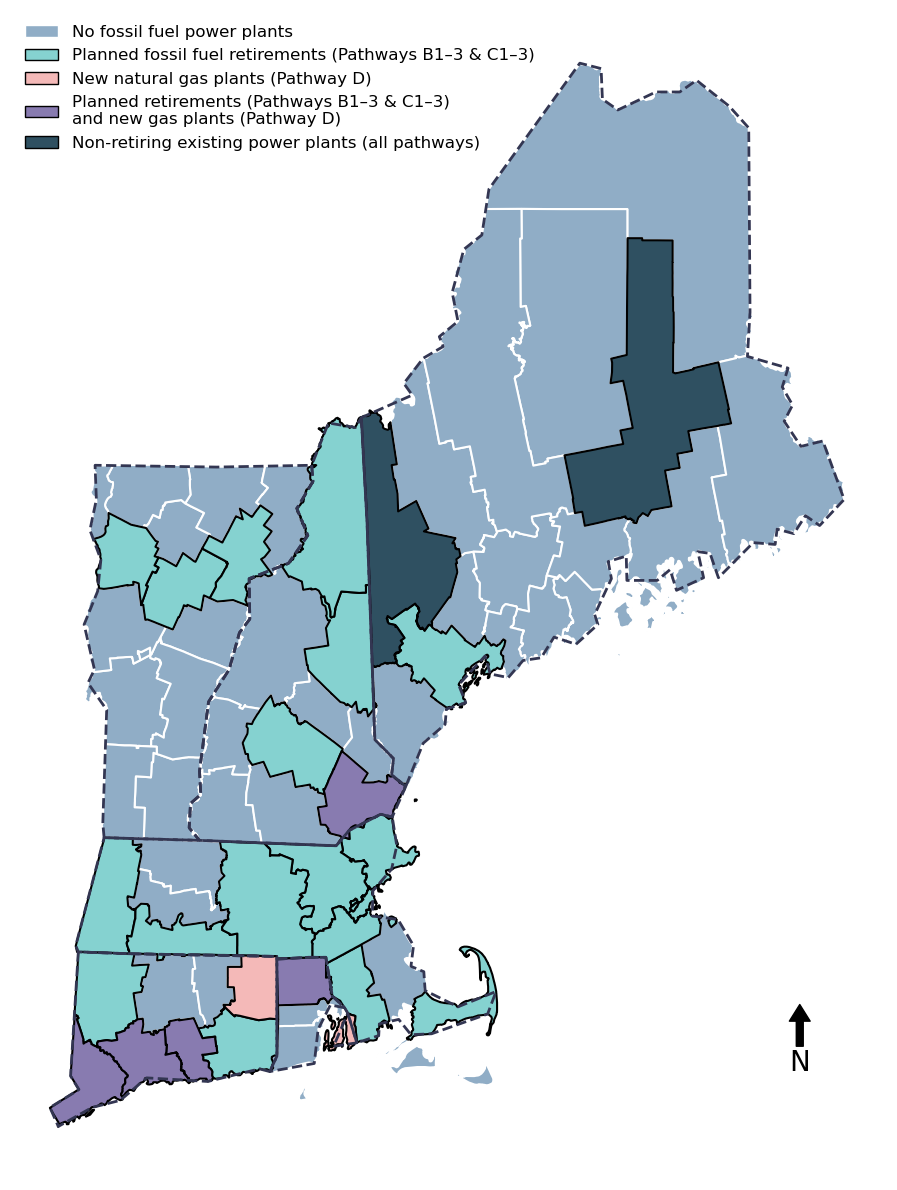

In [173]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# 1) File paths
retirement_data_path = (
    "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/"
    "2 Generation Expansion Model/2 Generation/2 Fossil Generation/"
    "1 Existing Fossil Fuels/1 Fossil Fuels Facilities Data/"
    "Fossil_Fuel_Facilities_Data.csv"
)
new_county_emissions_path = (
    "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/"
    "3 Total Costs/9 Total Costs Results/"
    "Air_Emissions_County_Level_New.csv"
)
county_geojson = (
    "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/"
    "4 External Data/U.S. Census Geo Data/"
    "New_England_county_boundaries.json"
)

# 2) Load data
ret_df = pd.read_csv(retirement_data_path, dtype={"Retirement_year": float})
new_cty = pd.read_csv(new_county_emissions_path)
counties = gpd.read_file(county_geojson)

# 3) Normalize county names: strip off " County"
for df in (ret_df, new_cty):
    df["County"] = (
        df["County"]
        .astype(str)
        .str.replace(r"\s*County$", "", regex=True)
        .str.strip()
    )
counties["County"] = (
    counties["name"]
    .astype(str)
    .str.replace(r"\s*County$", "", regex=True)
    .str.strip()
)

# 4) Map FIPS 'state' to two-letter codes
new_england_state_id    = ["23","33","50","25","44","09"]
new_england_state_codes = ["ME","NH","VT","MA","RI","CT"]
id_to_code = dict(zip(new_england_state_id, new_england_state_codes))
counties["State"] = counties["state"].map(id_to_code)

# 5) Flag counties
retire_by_year = 2050
retire_ct = (
    ret_df
    .loc[ret_df["Retirement_year"] <= retire_by_year, ["County","State"]]
    .drop_duplicates()
)
existing_ct = (
    ret_df
    .loc[ret_df["Retirement_year"] >= retire_by_year, ["County","State"]]
    .drop_duplicates()
)
new_ct = (
    new_cty
    .loc[new_cty["Pathway"] == "D", ["County","State"]]
    .drop_duplicates()
)
existing_ct = (
    ret_df
    .loc[ret_df["Retirement_year"] >= retire_by_year, ["County","State"]]
    .drop_duplicates()
)



set_ret = set(map(tuple, retire_ct.values))
set_new = set(map(tuple, new_ct.values))
only_ret = set_ret - set_new
only_new = set_new - set_ret
both     = set_ret & set_new
set_exist  = set(map(tuple, existing_ct.values))

idx = counties.set_index(["County","State"]).index
ret_gdf  = counties[idx.isin(only_ret)]
new_gdf  = counties[idx.isin(only_new)]
both_gdf = counties[idx.isin(both)]
exist_gdf         = counties[idx.isin(only_exist)]

# 6) State capitals
capitals = pd.DataFrame([
    #{"State":"ME","Name":"Augusta",      "Lon":-69.77949, "Lat":44.31062},
    #{"State":"NH","Name":"Concord",      "Lon":-71.53757, "Lat":43.20814},
    #{"State":"VT","Name":"Montpelier",   "Lon":-72.57539, "Lat":44.26006},
    {"State":"MA","Name":"Boston",       "Lon":-71.05888, "Lat":42.36008},
    #{"State":"RI","Name":"Providence",   "Lon":-71.41283, "Lat":41.82399},
    #{"State":"CT","Name":"Hartford",     "Lon":-72.67337, "Lat":41.76580},
])
capitals_gdf = gpd.GeoDataFrame(
    capitals,
    geometry=gpd.points_from_xy(capitals.Lon, capitals.Lat),
    crs="EPSG:4326"
)
if counties.crs:
    capitals_gdf = capitals_gdf.to_crs(counties.crs)

# 7) Plot
fig, ax = plt.subplots(figsize=(12,12))
counties.plot(ax=ax, facecolor="#90ADC6", edgecolor="white", linewidth=1.5)
ret_gdf .plot(ax=ax, facecolor="#85D2D0",   edgecolor="black", linewidth=1.5, alpha=1)
new_gdf .plot(ax=ax, facecolor="#F4B9B8",    edgecolor="black", linewidth=1.5, alpha=1)
both_gdf.plot(ax=ax, facecolor="#887BB0", edgecolor="black", linewidth=1.5, alpha=1)
exist_gdf.plot(ax=ax, facecolor="#2F5061", edgecolor="black", linewidth=1.5, alpha=1)

state_boundaries.boundary.plot(ax=ax, color="#333652", linestyle="--", linewidth=2, alpha=1)
    
# Capitals
#capitals_gdf.plot(ax=ax, marker="*", color="#FFF4BD", markersize=800, label="State Capital")


# Add a north arrow
x, y, arrow_length = 0.9, 0.1, 0.05  # Adjust position and size
ax.annotate('N', xy=(x, y + arrow_length), xytext=(x, y),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Legend
patch_none = mpatches.Patch(
    facecolor="#90ADC6", edgecolor="white",
    label="No fossil fuel power plants"
)

patch_retire = mpatches.Patch(
    facecolor="#85D2D0", edgecolor="black",
    label="Planned fossil fuel retirements (Pathways B1–3 & C1–3)"
)

patch_new = mpatches.Patch(
    facecolor="#F4B9B8", edgecolor="black",
    label="New natural gas plants (Pathway D)"
)

patch_both = mpatches.Patch(
    facecolor="#887BB0", edgecolor="black",
    label="Planned retirements (Pathways B1–3 & C1–3) \nand new gas plants (Pathway D)"
)

patch_non_retire = mpatches.Patch(
    facecolor="#2F5061", edgecolor="black",
    label="Non-retiring existing power plants (all pathways)"
)
ax.legend(handles=[patch_none,patch_retire,patch_new,patch_both,patch_non_retire],
          frameon=False, fontsize=12, loc="upper left")

#ax.set_title("New England Counties: Retirements vs New-Gas Candidates", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('Retirement_map.svg', dpi=300, bbox_inches='tight')
plt.show()


In [174]:
only_exist

{('Oxford', 'ME'), ('Penobscot', 'ME')}

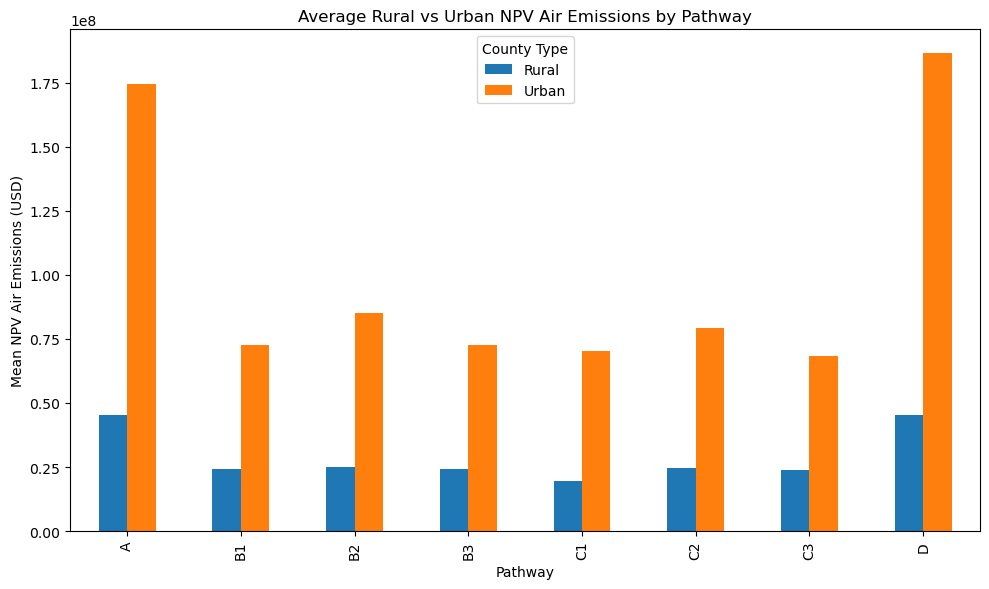

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Paths to your data
csv_existing = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_Existing.csv"
csv_new      = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_New.csv"
rucc_path    = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Department of Agriculture/RUCC 2023.csv"

# 2) Load the county‐level emissions
df_exist = pd.read_csv(csv_existing)
df_new   = pd.read_csv(csv_new)
emissions = pd.concat([df_exist, df_new], ignore_index=True)

# 3) Load RUCC CSV, only the columns we need; force a permissive encoding
rucc_raw = pd.read_csv(
    rucc_path,
    usecols=["State", "County_Name", "Attribute", "Value"],
    encoding="latin1",
    on_bad_lines="skip",
)

# 4) Filter to the RUCC_2023 rows and convert Value → integer code
rucc_codes = (
    rucc_raw[rucc_raw["Attribute"] == "RUCC_2023"]
    .loc[:, ["State", "County_Name", "Value"]]
    .rename(columns={"County_Name": "County", "Value": "RUCC"})
    .assign(RUCC=lambda df: pd.to_numeric(df["RUCC"], errors="coerce"))
    .dropna(subset=["RUCC"])
)
rucc_codes["RUCC"] = rucc_codes["RUCC"].astype(int)

# 5) Classify Urban vs Rural: codes 1–3 → Urban, 4–9 → Rural
rucc_codes["RuralUrban"] = np.where(rucc_codes["RUCC"] <= 3, "Urban", "Rural")

# 6) Normalize county names in both tables (strip " County" suffix) & uppercase state
for df in (emissions, rucc_codes):
    df["County"] = (
        df["County"].astype(str)
             .str.replace(r"\s*County$", "", regex=True)
             .str.strip()
    )
    df["State"] = df["State"].str.upper()

# 7) Merge the RUCC classification onto the emissions table
em = emissions.merge(
    rucc_codes[["State", "County", "RuralUrban"]],
    on=["State", "County"],
    how="left"
).dropna(subset=["RuralUrban"])

# 8) Aggregate NPV emissions by State, Pathway, Simulation, RuralUrban
grouped = (
    em
    .groupby(["State", "Pathway", "Simulation", "RuralUrban"], as_index=False)
    ["npv_total_air_emission_USD"]
    .sum()
    .rename(columns={"npv_total_air_emission_USD": "NPV"})
)

# 9) Compute mean across simulations for each State × Pathway × RuralUrban
mean_by_group = (
    grouped
    .groupby(["State", "Pathway", "RuralUrban"], as_index=False)
    ["NPV"]
    .mean()
    .rename(columns={"NPV": "Mean_NPV"})
)

# 10) (Optional) Pivot to compare Urban vs Rural averaged across all states for each Pathway
pivot = (
    mean_by_group
    .groupby(["Pathway", "RuralUrban"])["Mean_NPV"]
    .mean()
    .unstack("RuralUrban")  # columns: ['Rural', 'Urban']
)

# 11) Plot the comparison
ax = pivot.plot(kind="bar", figsize=(10,6))
ax.set_ylabel("Mean NPV Air Emissions (USD)")
ax.set_xlabel("Pathway")
ax.set_title("Average Rural vs Urban NPV Air Emissions by Pathway")
ax.legend(title="County Type")
plt.tight_layout()
plt.show()


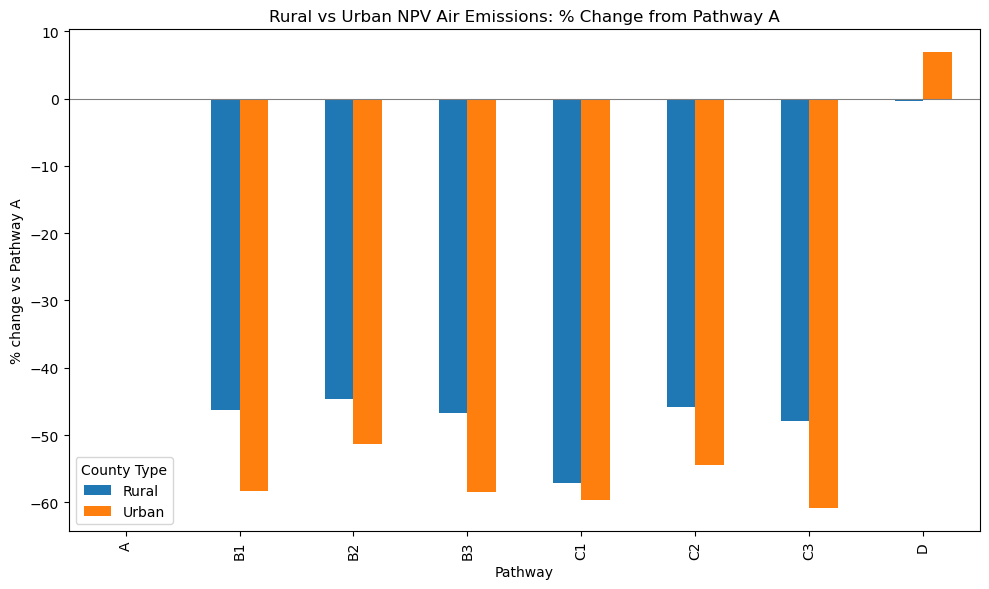

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Paths
csv_existing = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_Existing.csv"
csv_new      = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_New.csv"
rucc_path    = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Department of Agriculture/RUCC 2023.csv"

# 2) Load and combine existing+new emissions
df_exist  = pd.read_csv(csv_existing)
df_new    = pd.read_csv(csv_new)
emissions = pd.concat([df_exist, df_new], ignore_index=True)

# 3) Load RUCC, pick only the RUCC_2023 rows
rucc_raw = pd.read_csv(
    rucc_path,
    usecols=["State","County_Name","Attribute","Value"],
    encoding="latin1",
    on_bad_lines="skip"
)
rucc = (
    rucc_raw
    .query("Attribute=='RUCC_2023'")
    .rename(columns={"County_Name":"County","Value":"RUCC"})
    .assign(RUCC=lambda d: pd.to_numeric(d["RUCC"], errors="coerce"))
    .dropna(subset=["RUCC"])
)
rucc["RUCC"] = rucc["RUCC"].astype(int)
rucc["RuralUrban"] = np.where(rucc["RUCC"]<=3, "Urban", "Rural")

# 4) Normalize County & State codes
for df in (emissions, rucc):
    df["County"] = (
        df["County"].astype(str)
             .str.replace(r"\s*County$","",regex=True)
             .str.strip()
    )
    df["State"] = df["State"].str.upper()

# 5) Merge RUCC onto emissions, drop unmatched
em = emissions.merge(
    rucc[["State","County","RuralUrban"]],
    on=["State","County"],
    how="left"
).dropna(subset=["RuralUrban"])

# 6) Compute mean NPV by Pathway & RuralUrban (averaged across states & sims)
mean_ru = (
    em
    .groupby(["Pathway","Simulation","RuralUrban"], as_index=False)
    ["npv_total_air_emission_USD"]
    .sum()
    .groupby(["Pathway","RuralUrban"], as_index=False)
    ["npv_total_air_emission_USD"]
    .mean()
    .rename(columns={"npv_total_air_emission_USD":"Mean_NPV"})
)

# 7) Pivot so rows=Pathway, cols=RuralUrban
pivot = mean_ru.pivot(index="Pathway", columns="RuralUrban", values="Mean_NPV")

# 8) Compute percent change vs baseline Pathway A
baseline = pivot.loc["A"]
pct_change = (pivot.subtract(baseline))\
                .divide(baseline)\
                .multiply(100)

# 9) Plot
ax = pct_change.plot(kind="bar", figsize=(10,6))
ax.axhline(0, color="gray", linewidth=0.8)
ax.set_ylabel("% change vs Pathway A")
ax.set_xlabel("Pathway")
ax.set_title("Rural vs Urban NPV Air Emissions: % Change from Pathway A")
ax.legend(title="County Type")
plt.tight_layout()
plt.show()


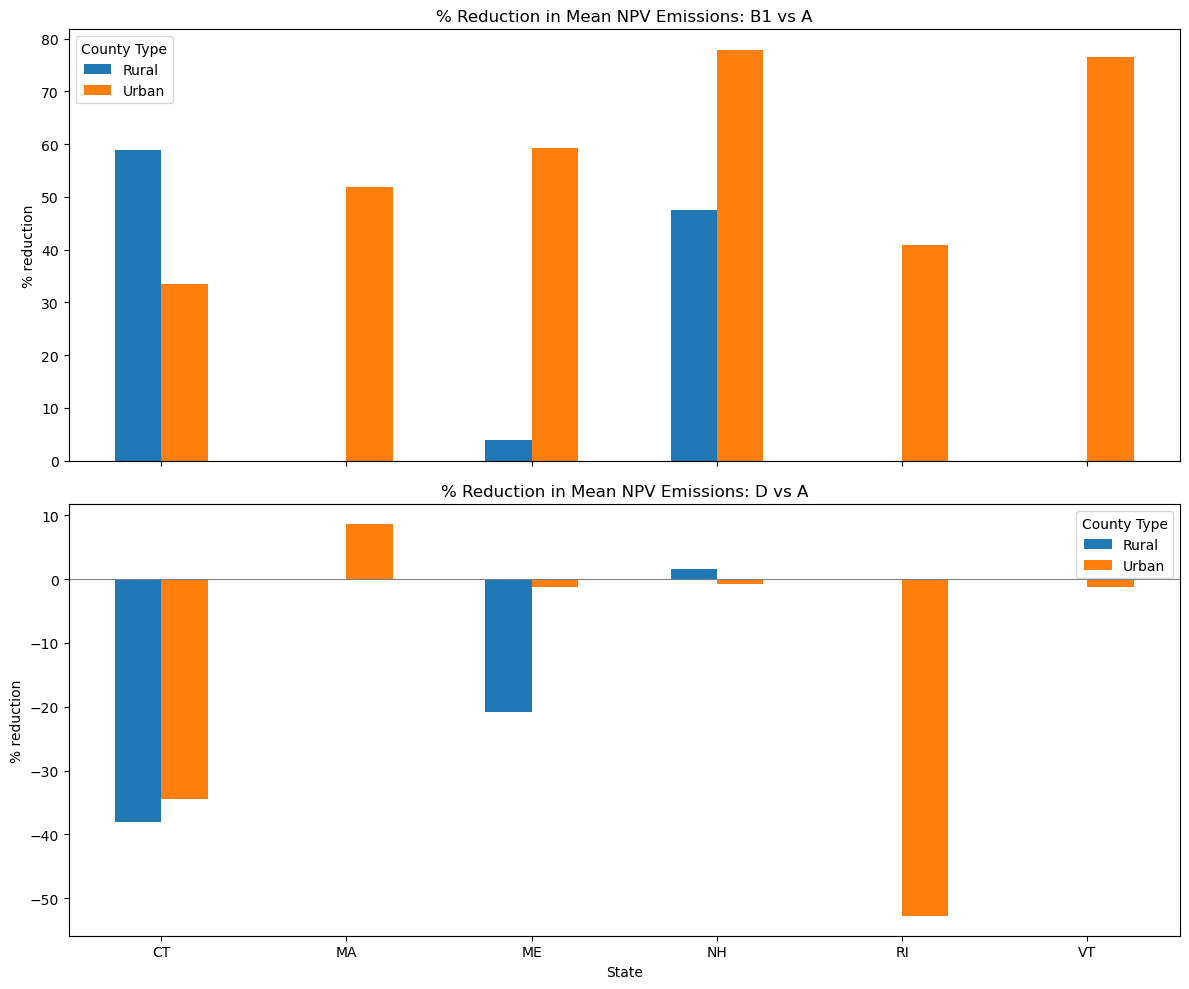

In [180]:
import pandas as pd
import numpy as np

# 1) Paths
csv_existing = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_Existing.csv"
csv_new      = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/9 Total Costs Results/Air_Emissions_County_Level_New.csv"
rucc_path    = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/4 External Data/U.S. Department of Agriculture/RUCC 2023.csv"

# 2) Load & combine emissions
df_exist  = pd.read_csv(csv_existing)
df_new    = pd.read_csv(csv_new)
emissions = pd.concat([df_exist, df_new], ignore_index=True)

# normalize names
emissions["County"] = (
    emissions["County"].astype(str)
               .str.replace(r"\s*County$", "", regex=True)
               .str.strip()
)
emissions["State"] = emissions["State"].str.upper()

# 3) Read RUCC, keep only RUCC_2023
rucc_raw = pd.read_csv(
    rucc_path,
    usecols=["State","County_Name","Attribute","Value"],
    encoding="latin1",
    on_bad_lines="skip"
)
rucc_codes = (
    rucc_raw[rucc_raw["Attribute"]=="RUCC_2023"]
    .rename(columns={"County_Name":"County","Value":"RUCC"})
    .assign(RUCC=lambda df: pd.to_numeric(df["RUCC"], errors="coerce"))
    .dropna(subset=["RUCC"])
)
rucc_codes["RUCC"] = rucc_codes["RUCC"].astype(int)
rucc_codes["State"] = rucc_codes["State"].str.upper()

# classify rural vs urban
rucc_codes["RuralUrban"] = np.where(rucc_codes["RUCC"]<=3, "Urban", "Rural")

# strip suffix from County column
rucc_codes["County"] = (
    rucc_codes["County"]
    .astype(str)
    .str.replace(r"\s*County$", "", regex=True)
    .str.strip()
)

# 4) Separate non-CT and CT entries
non_ct = rucc_codes[rucc_codes["State"]!="CT"][["State","County","RUCC","RuralUrban"]]

ct_raw = rucc_codes[rucc_codes["State"]=="CT"].copy()
# ct_raw["County"] currently holds planning-region names, not actual counties

# 5) Define mapping from CT planning-region → actual counties
#    These keys match the stripped 'County' values in ct_raw
mapping = {
    "Capitol Planning Region":               ["Hartford","Tolland"],
    "Greater Bridgeport Planning Region":    ["Fairfield"],
    "Lower Connecticut River Valley Planning Region": ["Middlesex"],
    "Naugatuck Valley Planning Region":      ["New Haven"],
    "Northeastern Connecticut Planning Region":    ["Windham"],
    "Northwest Hills Planning Region":       ["Litchfield"],
    "South Central Connecticut Planning Region":    ["New Haven"],
    "Southeastern Connecticut Planning Region":    ["New London","Windham"],
    "Western Connecticut Planning Region":   ["Litchfield"]
}

# But ct_raw["County"] is stripped: drop the " Planning Region" suffix
ct_raw["Region"] = (
    ct_raw["County"]
    .str.replace(r"\s*Planning Region$", "", regex=True)
    .str.strip()
)

# 6) Build a DataFrame of actual CT counties with RUCC & RuralUrban
rows = []
for raw_name, counties in mapping.items():
    # find the row in ct_raw by matching Region
    region_key = raw_name.replace(" Planning Region","")
    entry = ct_raw.loc[ct_raw["Region"] == region_key]
    if entry.empty:
        raise KeyError(f"No RUCC entry for region '{raw_name}'")
    code = int(entry["RUCC"].iloc[0])
    ru = entry["RuralUrban"].iloc[0]
    for county in counties:
        rows.append({
            "State":      "CT",
            "County":     county,
            "RUCC":       code,
            "RuralUrban": ru
        })

ct_manual = pd.DataFrame(rows)

# 7) Combine non-CT and manual-CT
final_rucc = pd.concat([non_ct, ct_manual], ignore_index=True)

# 8) Merge onto emissions
em = (
    emissions
    .merge(final_rucc, on=["State","County"], how="left")
    .dropna(subset=["RuralUrban"])
)

# 6) For each State, Pathway, Simulation, RuralUrban: sum NPV
state_sim_ru = (
    em
    .groupby(["State","Pathway","Simulation","RuralUrban"], as_index=False)
    ["npv_total_air_emission_USD"]
    .sum()
    .rename(columns={"npv_total_air_emission_USD":"NPV"})
)

# 7) Average over simulations: State × Pathway × RuralUrban
state_path_ru = (
    state_sim_ru
    .groupby(["State","Pathway","RuralUrban"], as_index=False)
    ["NPV"]
    .sum()
    .rename(columns={"NPV":"Mean_NPV"})
)

# 8) Pivot so each row is (State, RuralUrban) and columns are pathways A, B1, D
wide = (
    state_path_ru
    .pivot(index=["State","RuralUrban"], columns="Pathway", values="Mean_NPV")
    .reset_index()
)

#  Drop any rows missing A, B1 or D
wide = wide.dropna(subset=["A","B1","D"])

# 9) Compute percent reduction relative to A:
#    positive means reduction, negative means increase
wide["B1_vs_A_pct"] = (wide["A"] - wide["B1"]) / wide["A"] * 100
wide["D_vs_A_pct"]  = (wide["A"] - wide["D"])  / wide["A"] * 100

# 10) Plot B1 → A and D → A side by side for each state & rural/urban
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# B1 vs A
df_b1 = wide.pivot(index="State", columns="RuralUrban", values="B1_vs_A_pct")
df_b1.plot(kind="bar", ax=axes[0])
axes[0].set_title("% Reduction in Mean NPV Emissions: B1 vs A")
axes[0].set_ylabel("% reduction")
axes[0].legend(title="County Type")
axes[0].axhline(0, color="gray", linewidth=0.8)

# D vs A
df_d = wide.pivot(index="State", columns="RuralUrban", values="D_vs_A_pct")
df_d.plot(kind="bar", ax=axes[1])
axes[1].set_title("% Reduction in Mean NPV Emissions: D vs A")
axes[1].set_ylabel("% reduction")
axes[1].legend(title="County Type")
axes[1].axhline(0, color="gray", linewidth=0.8)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [181]:
df_d

RuralUrban,Rural,Urban
State,,
CT,-38.075988,-34.537842
MA,NaN,8.622664
ME,-20.857625,-1.256455
NH,1.545019,-0.694071
RI,NaN,-52.817414
VT,NaN,-1.203862


In [182]:
df_b1

RuralUrban,Rural,Urban
State,,
CT,58.876901,33.452948
MA,NaN,51.808961
ME,3.942374,59.215725
NH,47.523658,77.865033
RI,NaN,40.862531
VT,NaN,76.484760


/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_43895/503122471.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(drop_iqr_outliers)


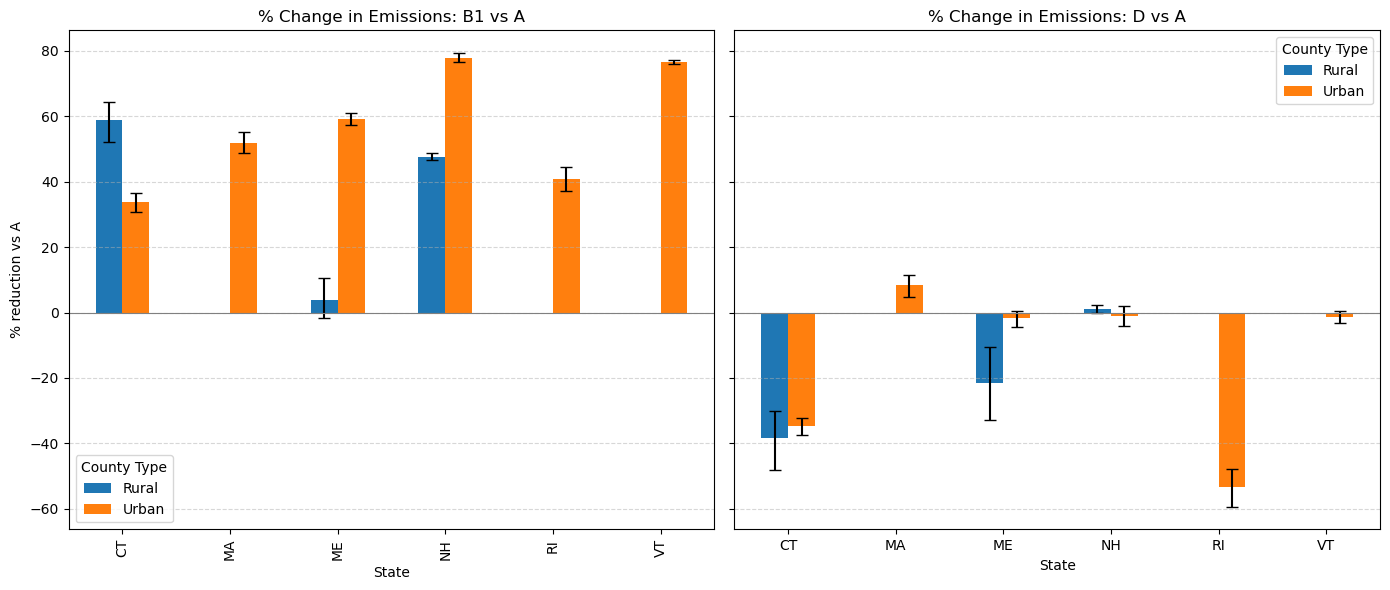

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# — assume `state_sim_ru` exists with columns: 
#   ['State','Pathway','Simulation','RuralUrban','NPV']

# 1) Drop outliers per State/Pathway/RuralUrban
def drop_iqr_outliers(df):
    q1, q3 = df["NPV"].quantile([0.25, 0.75])
    iqr = q3 - q1
    return df[df["NPV"].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

clean = (
    state_sim_ru
    .groupby(["State","Pathway","RuralUrban"], group_keys=False)
    .apply(drop_iqr_outliers)
)

# 2) Pivot so each sim has columns A, B1, D
df_sim = (
    clean
    .pivot(index=["State","RuralUrban","Simulation"], columns="Pathway", values="NPV")
    .reset_index()
    .dropna(subset=["A","B1","D"])
)

# 3) Percent change vs A in each sim
df_sim["B1_vs_A_pct"] = (df_sim["A"] - df_sim["B1"]) / df_sim["A"] * 100
df_sim["D_vs_A_pct"]  = (df_sim["A"] - df_sim["D"])  / df_sim["A"] * 100

# 4) Aggregate mean/min/max of percent changes per State × RuralUrban
stats_pct = (
    df_sim
    .groupby(["State","RuralUrban"], as_index=False)
    .agg(
        B1_mean_pct=("B1_vs_A_pct","mean"),
        B1_min_pct =("B1_vs_A_pct","min"),
        B1_max_pct =("B1_vs_A_pct","max"),
        D_mean_pct =("D_vs_A_pct","mean"),
        D_min_pct  =("D_vs_A_pct","min"),
        D_max_pct  =("D_vs_A_pct","max"),
    )
)



# 6) Plot bar charts with asymmetric error bars
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, (mean_col, min_col, max_col, title) in zip(
    axes,
    [
      ("B1_mean_pct","B1_min_pct","B1_max_pct","B1 vs A"),
      ("D_mean_pct", "D_min_pct", "D_max_pct","D vs A")
    ]
):
    # pivot mean values
    dfp = stats_pct.pivot(index="State", columns="RuralUrban", values=mean_col)
    # compute low/high errors per series
    err_low  = dfp.values - stats_pct.pivot(index="State", columns="RuralUrban", values=min_col).values
    err_high = stats_pct.pivot(index="State", columns="RuralUrban", values=max_col).values - dfp.values
    
    # build yerr array of shape (n_series, 2, n_states)
    n_states, n_series = dfp.shape[0], dfp.shape[1]
    yerr = np.zeros((n_series, 2, n_states))
    # err_low and err_high are shape (n_states, n_series)
    yerr[:, 0, :] = err_low.T   # low errors
    yerr[:, 1, :] = err_high.T  # high errors

    dfp.plot(
        kind="bar",
        ax=ax,
        yerr=yerr,
        capsize=4
    )
    ax.axhline(0, color="gray", linewidth=0.8)
    ax.set_title(f"% Change in Emissions: {title}")
    ax.set_ylabel("% reduction vs A")
    ax.set_xlabel("State")
    ax.legend(title="County Type")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [184]:
stats_pct

,State,RuralUrban,B1_mean_pct,B1_min_pct,B1_max_pct,D_mean_pct,D_min_pct,D_max_pct
0,CT,Rural,58.981085,52.097404,64.480462,-38.328978,-48.045692,-30.052223
1,CT,Urban,33.744035,30.865428,36.644767,-34.790997,-37.549328,-32.126649
2,MA,Urban,51.918951,48.723729,55.075974,8.270855,4.701029,11.509094
3,ME,Rural,3.943272,-1.717098,10.647650,-21.401960,-32.720691,-10.560278
4,ME,Urban,59.208837,57.446971,60.974532,-1.759643,-4.530357,0.355422
5,NH,Rural,47.596917,46.562978,48.636653,1.133053,-0.154957,2.256024
6,NH,Urban,77.936002,76.483291,79.318875,-1.015121,-4.193580,1.840819
7,RI,Urban,40.949508,36.990780,44.429402,-53.374246,-59.309660,-47.942230
8,VT,Urban,76.654358,76.054820,77.093900,-1.403707,-3.136860,0.335400


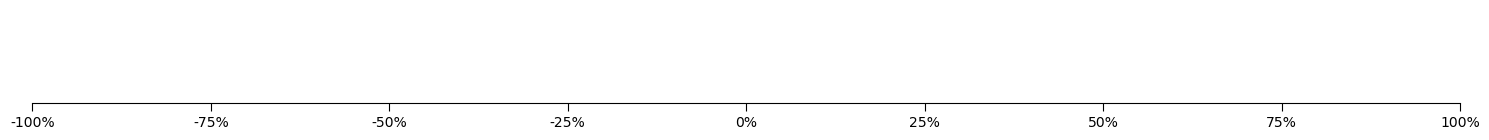

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# create figure and axis
fig, ax = plt.subplots(figsize=(15, 1.5))

# set x-limits from -100 to +100
ax.set_xlim(-100, 100)

# set ticks every 25 units
ticks = np.arange(-100, 101, 25)
ax.set_xticks(ticks)

# format ticks as percentages
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d%%'))

# hide everything but the bottom spine and ticks
ax.get_yaxis().set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_position(('outward', 0))

# draw tick lines outward only
ax.tick_params(axis='x', direction='out', length=6)

plt.tight_layout()
plt.savefig('Ruler.svg', dpi=300, bbox_inches='tight')
plt.show()
